In [3]:
import os
import pandas as pd
import numpy as np
import time
import re
import codecs
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import datetime
from scipy.spatial.distance import cosine

nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to /Users/hojinlee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import data

Please change the directories based on your local machine

In [4]:
#Please change directories based on your local machine
country_directory = r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/peace-speech-project_master/data/preprocessed/lemmatized/IN'

conflict = pd.read_excel(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/peace-speech-project_master/lexicon_list/enh_conflict_lexicon.xlsx')
peace = pd.read_excel(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/peace-speech-project_master/lexicon_list/enh_peace_lexicon.xlsx')
resilence = pd.read_excel(r'/Users/hojinlee/Documents/Columbia/2020/Fall2020/peace-speech-project_master/lexicon_list/enh_resilience_lexicon.xlsx')



In [21]:
#Read Files from local machine
start_time = datetime.datetime.now()
df_dict_country = {"id": [], "title": [], "publisher": [], "article_text":[],"url":[], "path":[]}
for entry_publisher in os.scandir(country_directory):
    for entry_year in os.scandir(entry_publisher.path):
        for entry_final in os.scandir(entry_year.path):
            try:
                with open(entry_final, "r") as f:
                    article_id = f.readline().strip()
                    article_title = f.readline().strip()
                    publisher = f.readline().strip()
                    url = f.readline()
                    f.readline()
                    f.readline()
                    article_text = f.readline().strip()
                    df_dict_country['url'].append(url)
                    df_dict_country['id'].append(article_id)
                    df_dict_country['title'].append(article_title)
                    df_dict_country['publisher'].append(publisher)
                    df_dict_country['article_text'].append(article_text)
                    df_dict_country['path'].append(entry_final.name)
            except:
                pass
end_time = datetime.datetime.now()

In [22]:
#time taken for reading one country
end_time - start_time

datetime.timedelta(seconds=12, microseconds=299778)

In [23]:
df_dict_country = pd.DataFrame.from_dict(df_dict_country)

In [24]:
df_dict_country

,id,title,publisher,article_text,url,path
0,4853383,"Xi Jinping reminds Hong Kong, Macau are part o...",News Nation,xi jinping reminds hong kong macau part one ch...,http://www.newsnation.in/article/64386-xi-jinp...,4853383_IN_20-12-14.txt
1,4932562,Ramachandra Guha's new collection of essays ac...,News Nation,ramachandra guha 's new collection essay acqui...,http://www.newsnation.in/article/105187-ramach...,4932562_IN_22-12-15.txt
2,2133985,US strike kills head of IS in Libya: Pentagon,News Nation,u strike kill head libya pentagon head islamic...,http://www.newsnation.in/article/97317-us-stri...,2133985_IN_14-11-15.txt
3,4865177,Bengal hosts large percentage of country's chi...,News Nation,bengal host large percentage country 's child ...,http://www.newsnation.in/article/99561-bengal-...,4865177_IN_25-11-15.txt
4,2113162,"AwardWapsi: Amish Tripathi, author of Shiva Tr...",News Nation,amish tripathi author shiva triology criticise...,http://www.newsnation.in/article/95663-awardwa...,2113162_IN_03-11-15.txt
...,...,...,...,...,...,...
109849,7544336,9th session of XLRI Leadership Series held,Avenue Mail,th session xlri leadership series hold jamshed...,http://www.avenuemail.in/jamshedpur/9th-sessio...,7544336_IN_06-03-16.txt
109850,8497487,State government committed to uplift the condi...,Avenue Mail,state government commit uplift condition poor ...,http://www.avenuemail.in/ranchi/state-govt-com...,8497487_IN_26-04-16.txt
109851,14207504,"CM participates at Kadma Ganesh Puja, prays fo...",Avenue Mail,cm participate kadma ganesh puja prays prosper...,http://www.avenuemail.in/jamshedpur/cm-partici...,14207504_IN_05-09-16.txt
109852,15734846,"HR conference at XLRI, Day two focuses on econ...",Avenue Mail,hr conference xlri day two focus economic impl...,http://www.avenuemail.in/jamshedpur/hr-confere...,15734846_IN_04-12-16.txt


## Word Frequency Analysis with visualization

create_vocab_dict: creates the vocab dictionary based on the lexicons from *peace*, *conflict*, *resilence*; have only counted lexicons less than 5 words (4-gram max)

word_freq: uses Countvectorizer to creates the dictionary with word counts {str(word):int(count)}

plot_n_most_common_words: using the dictionary with word counts, output the graph with given integer n.

In [9]:
conflict['label'] = 'conflict'
peace['label'] = 'peace'
resilence['label'] = 'resilence'
conflict = conflict.loc[:,['Term', 'label']]
peace['Term'] = peace['academic freedom']
peace = peace.loc[:,['Term', 'label']]
resilence = resilence.loc[:,['Term', 'label']]

vocab_df = conflict.copy()
vocab_df = vocab_df.append(peace)
vocab_df = vocab_df.append(resilence)
vocab_df.index = np.arange(0, len(vocab_df))

In [10]:
#Create dictionary for the vocab in CountVectorizer
def create_vocab_dict(vocab_df):
    vocabs = vocab_df.Term.str.lower()
    vocabs = list(set(vocabs))
    vocab_dictionary = {}
    idx = 0
    for vocab in vocabs:
        voc_len = len(word_tokenize(vocab))
        if voc_len < 5:
            vocab_dictionary[vocab] = idx
            idx += 1
    return vocab_dictionary

In [15]:
#Using Countvectorizer to count all the n-grams
def word_freq(df, vocab_dictionary):
    count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,4), vocabulary= vocab_dictionary)
    count_data = count_vectorizer.fit_transform(df.article_text)
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
  
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key = lambda x:x[1], reverse = True)

    return count_dict

In [16]:
def plot_n_most_common_words(count_dict, n):
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title= str(n) + ' most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

In [17]:
vocab_dictionary = create_vocab_dict(vocab_df)

### Create Word Freq

If you have used different columns for cleaned_text, please add another column or change the column name to text.

In [26]:
#df_dict_country['text'] = df_dict_country['article_text']
start_time = datetime.datetime.now()
count_dict= word_freq(df_dict_country, vocab_dictionary)
end_time = datetime.datetime.now()

In [27]:
#Time taken for creating count_dict
end_time - start_time

datetime.timedelta(seconds=77, microseconds=458448)

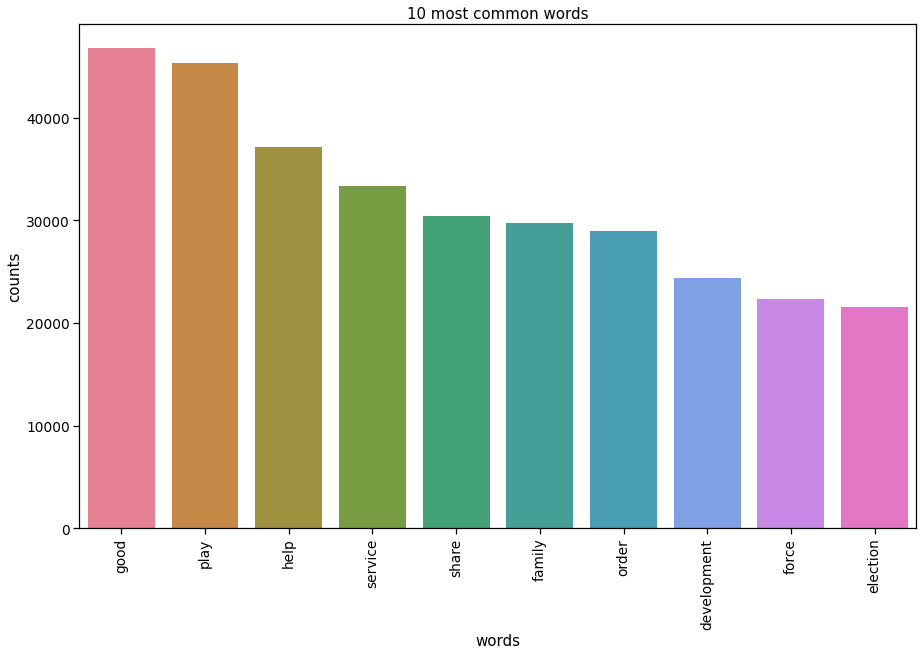

In [28]:
plot_n_most_common_words(count_dict, 10)